In [1]:
import pandas as pd
import matplotlib.pyplot as plt # For exploratory analysis prior to building a website (make sure there is a story to be told)

In [2]:
RAW_DATA_PATH: str = "owid-covid-data.csv"

In [3]:
raw_df = pd.read_csv(RAW_DATA_PATH)

C:\Users\zaidn\AppData\Local\Temp\ipykernel_24752\1361761233.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(RAW_DATA_PATH)


In [4]:
raw_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [5]:
raw_df[raw_df['iso_code'] == 'USA'].columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Data retrieved from "Our World in Data" site (https://ourworldindata.org/covid-deaths), as of July 14th, 2024. Additional information can be found in their repo: https://github.com/owid/covid-19-data/tree/master/public/data
Represents cases and deaths reported by the World Health Organization for 219 countries, updated daily.

Relavent columns available:

- iso_code: Identifier for this location / country (ex. USA for United States)
- continent: Continent of this location / country.
- location: Country of origin for this data point.
- date: Reported date for this data point.
- total_cases: Rolling total cases for this location / country to-date.
- new_cases: Newly reported cases for this date and location.
- new_cases_smoothed: Newly reported cases (7-day smoothed).
- total_deaths: Rolling total deaths for this location / country to-date.
- new_deaths: Newly reported deaths for this date and location.
- new_deaths_smoothed: Newly reported deaths (7-day smoothed).

Unexplored columns:

- reproduction_rate
- icu_patients
- hosp_patients
- weekly_icu_admissions
- total_tests
- new_tests
- positive_rate
- tests_per_case
- total_vaccinations
- people_vaccinated
- people_fully_vaccinated
- total_boosters
- population_density
- median age
- gdp_per_capita
- population
- human_development_index

# Data Transformations

In [6]:
# Keep only inscope columns
COLUMNS = [
    "iso_code",
    "continent",
    "location",
    "date",
    "new_cases",
    "new_deaths",
    "new_cases_smoothed",
    "new_deaths_smoothed",
    "population",
    "total_deaths",
    "total_cases",
    "total_deaths_per_million",
    "total_cases_per_million",
]
raw_df = raw_df[COLUMNS]

# Filter from Feb 2020 to May 2023 since many locations did not report outside of this window
raw_df = raw_df[(raw_df['date'] >= '2020-02-01') & (raw_df['date'] < '2023-06-01')]

# Filter out a few locations with severely underreported data that make visualization difficult / misleading 
#(filling N/A will result in these locations looking like they have an excellent control of covid when the reality is the data just wasn't being tracked)
raw_df = raw_df[~raw_df['location'].isin(['Macao', 'Northern Cyprus', 'Western Sahara'])]

In [7]:
# Truncate date to month
raw_df['date'] = raw_df['date'].str.slice(0, 7)

In [8]:
# Get total cases / deaths per million for the end of each month for scatterplot
counts_per_million = raw_df.groupby(by=['iso_code', 'continent', 'location', 'date', 'population'], dropna=False).last().reset_index()[
    ['iso_code', 'continent', 'location', 'date', 'population', 'total_cases_per_million', 'total_deaths_per_million']
]

In [9]:
# Group by location and month to obtain 40 months of data for each location
# 252 locations x 40 months = 10,080 rows
raw_df = raw_df.drop(columns=['total_cases_per_million', 'total_deaths_per_million'])
transformed_df = raw_df.groupby(by=['iso_code', 'continent', 'location', 'date', 'population'], dropna=False).sum(min_count=1).reset_index()

In [10]:
transformed_df = transformed_df.merge(counts_per_million, on=['iso_code', 'continent', 'location', 'date', 'population'])

In [11]:
# Write data to json output file
transformed_df.to_json('transformed_covid_data.json', orient="records")

# What does the data look like?

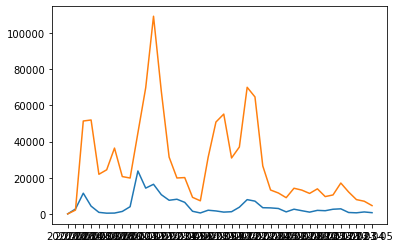

In [12]:
FIELD = 'new_deaths'
blue_location = 'France'
orange_location = 'United States'

x = transformed_df[transformed_df['location'] == blue_location]
y = transformed_df[transformed_df['location'] == orange_location]
plt.plot(x['date'], x[FIELD], label = blue_location)
plt.plot(y['date'], y[FIELD], label = orange_location)
plt.show()